In [76]:
import numpy as np
import matplotlib.pyplot as plt
from lammps import lammps 


class SimpleLammps():
    def __init__(self,N_D=55):
        self.N_D = N_D
        self.L = lammps(cmdargs=['-log','none','-screen','none'])
        """ 
            SUPER SIMPLE- MAKE A VACANCY THEN MOVE IT
        """ 
        self.L.commands_string(f"""
            units metal
            atom_style atomic
            atom_modify map array sort 0 0.0
            dimension 3
            timestep 0.001
            boundary p p p
            
            lattice bcc 3.18
            region C block 0 3 0 3 0 3 units lattice
            region mid block 2.4 2.6 2.4 2.6 2.4 2.6 units lattice
            create_box 1 C
            create_atoms 1 region C
            group mid region mid
            delete_atoms group mid
            
            mass * 184.0
            pair_style snap
            pair_coeff * * W.snapcoeff W.snapparam W
            
            fix seal all nve
            minimize  0 0 100 100
            write_data initial.dat

            compute dD all snad/atom 4.7 0.99363 8 0.5 1
            compute D all sna/atom 4.7 0.99363 8 0.5 1
            run 0
        """)
        self.D_i = self.get_D()
        self.X_i = self.get_X()
        self.N = self.X_i.shape[0]
        self.W_i = np.diag(1.0/np.sqrt(0.01+(L.get_D()**2).mean(0)))/self.N

        self.L.commands_string(""" 
            region sel block 2.9 3.1 2.9 3.1 2.9 3.1 units lattice
            group sel region sel
            displace_atoms sel move -0.5 -0.5 -0.5 units lattice
            minimize 0 0 100 100
            write_data final.dat
        """)
        self.D_f = self.get_D()
        self.X_f = self.get_X()
        print("In final vacancy configuration")

    def get_D(self):
        return np.ctypeslib.as_array(
            self.L.gather("c_D",1,self.N_D)).reshape((-1,self.N_D))

    def get_dD(self):
        """ snad/atom returns negative gradient !"""
        return -np.ctypeslib.as_array(
            self.L.gather("c_dD",1,3*self.N_D)).reshape((-1,3,self.N_D))

    def get_X(self):
        return np.ctypeslib.as_array(
            self.L.gather("x",1,3)).reshape((-1,3))
    
    def set_X(self,X):
        self.L.scatter("x",1,3,np.ctypeslib.as_ctypes(X.flatten()))
        self.L.command("run 0")

    def get_loss(self,W=None,Di=None):
        if W is None:
            W = self.W_i
        if Di is None:
            Di = self.D_i
        D_diff = self.get_D()-Di
        return 0.5 * np.sum(D_diff@W * D_diff)
        
    def get_loss_grad_X(self,W=None,Di=None):
        """ 
            d/dX [D(X)-D_i].W.[D(X)-D_i]/2
            =
            dD(X).W.[]
        """ 
        if W is None:
            W = self.W_i
        if Di is None:
            Di = self.D_i
        return np.einsum('ijk,ik->ij',self.get_dD(),(self.get_D()-Di)@W)
    
    def euler_steps(self,X,n=10,dt=0.01,W=None,Di=None):
        if W is None:
            W = self.W_i
        if Di is None:
            Di = self.D_i
        X_i = X.copy()
        self.set_X(X_i)
        
        for step in range(n):
            dX = self.get_loss_grad_X(W,Di)
            self.set_X(X-dX*dt)
            print(self.get_loss())
        return X_i,self.get_X(),dX


In final vacancy configuration
6.012273249425406
5.981273474628837
5.9864923059639334
5.982146661729949
5.983245698761731
5.98251471748698
5.982682587219617
5.982553610795094
5.982579280609327
5.982555418554748


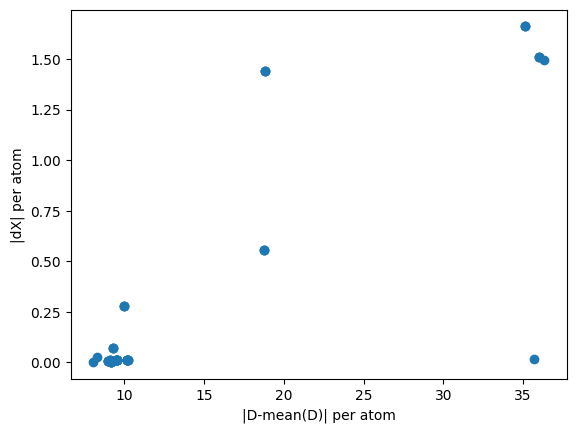

In [79]:
L = SimpleLammps()
X_i,X_f,dX=L.euler_steps(L.X_f)

D = L.get_D()
D -= D.mean(0)[None,:] # mean over box
plt.ylabel("|dX| per atom")
plt.xlabel("|D-mean(D)| per atom")
# expect |D|>0 for atoms where |dX| is small as they can be next to moving atoms
# i.e. points in bottom right but not top left
plt.scatter(np.linalg.norm(D,axis=1),np.linalg.norm(dX,axis=1))
